## Vision Transformers

In this notebook, we will define and implement the Vision Transformer model. 

# Data Loading and Preprocessing
In this section, we will load the CIFAR-10 dataset and perform basic preprocessing. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes. We will apply the following preprocessing steps:
- Resize images to 32x32 pixels.
- Normalize the pixel values to a range of [-1, 1].
- Visualize some sample images from the dataset.


Files already downloaded and verified
Files already downloaded and verified


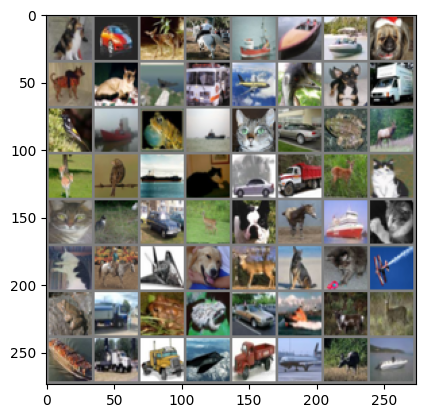

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Function to visualize sample images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))


# Patch Embedding
The PatchEmbed class is defined to split the input images into smaller patches and embed these patches into vectors. This process involves:
- Dividing each 32x32 image into 4x4 patches.
- Using a convolutional layer to project these patches into a lower-dimensional embedding space.
- Flattening the patches and rearranging them for further processing in the transformer model.


In [70]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size * self.grid_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x


# Task:
Task: Modify the PatchEmbed class to include overlapping patches by adjusting the stride. Visualize the overlapping patches.
Question: What is the Impact of Overlapping Patches on Model Performance



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


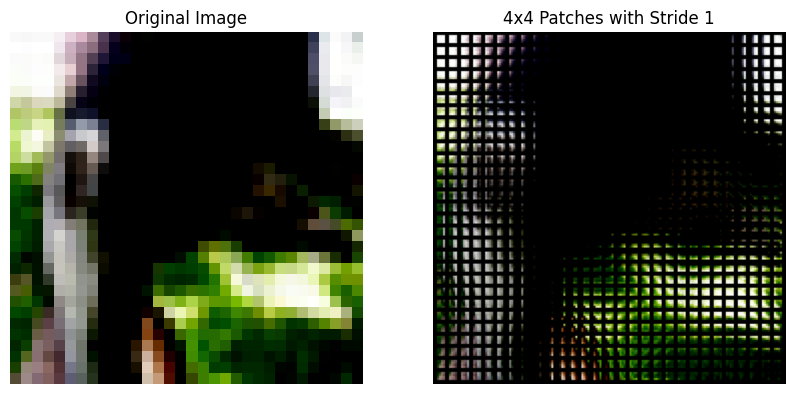

In [95]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, stride=2, in_chans=3, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.stride = stride
        self.grid_size = (img_size - patch_size) // stride + 1
        self.num_patches = self.grid_size ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Visualization Function
def visualize_overlapping_patches(image, patch_size, stride):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    patches = image.unfold(1, patch_size, stride).unfold(2, patch_size, stride)
    patches = patches.permute(1, 2, 0, 3, 4).reshape(-1, 3, patch_size, patch_size)

    grid_img = np.transpose(torchvision.utils.make_grid(patches, nrow=int((32 - patch_size) / stride + 1)), (1, 2, 0))
    axes[1].imshow(grid_img)
    axes[1].set_title(f"{patch_size}x{patch_size} Patches with Stride {stride}")
    axes[1].axis('off')

    plt.show()

example_image = images[13]
visualize_overlapping_patches(example_image, patch_size=4, stride=1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Patches shape: torch.Size([1, 225, 64])


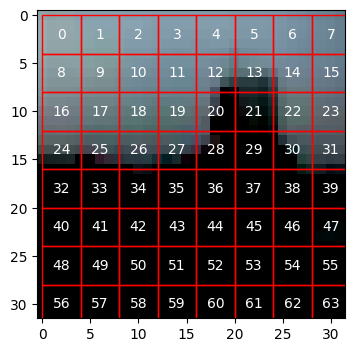

In [99]:
# Function to visualize the patches
def show_patches(img, patch_size, stride):
    img = img.numpy().transpose(1, 2, 0)
    fig, ax = plt.subplots(figsize=(4, 4))
    for i in range(0, img.shape[0] - patch_size + 1, stride):
        for j in range(0, img.shape[1] - patch_size + 1, stride):
            rect = plt.Rectangle((j, i), patch_size, patch_size, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    ax.imshow(img)
    plt.show()

def show_patches_with_numbers(img, patch_size, stride):
    img = img.numpy().transpose(1, 2, 0)
    fig, ax = plt.subplots(figsize=(4, 4))
    patch_id = 0
    for i in range(0, img.shape[0]- patch_size + 1, stride):
        for j in range(0, img.shape[1]- patch_size + 1, stride):
            rect = plt.Rectangle((j, i), patch_size, patch_size, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(j + patch_size // 2, i + patch_size // 2, str(patch_id), color='white', ha='center', va='center')
            patch_id += 1
    ax.imshow(img)
    plt.show()

# Example of Patch Embedding
patch_embed = PatchEmbed()
example_image = images[17].unsqueeze(0)  # Use one image
patches = patch_embed(example_image)
print(f'Patches shape: {patches.shape}')
show_patches_with_numbers(images[17], 4,4)

# Positional Encoding
The PositionalEncoding class adds positional information to the embedded patches. This step is crucial because the transformer model does not inherently understand the order or positions of the patches. By adding positional encodings, we provide the model with information about the spatial relationships between the patches.


In [87]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, num_patches):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

    def forward(self, x):
        x = x + self.pos_embed[:, :x.size(1), :]
        return x
    def visualize_positional_encoding(self):
        pos_enc = self.pos_embed.detach().cpu().numpy().squeeze(0)
        plt.imshow(pos_enc, cmap='viridis')
        plt.title('Positional Encodings')
        plt.colorbar()
        plt.show()



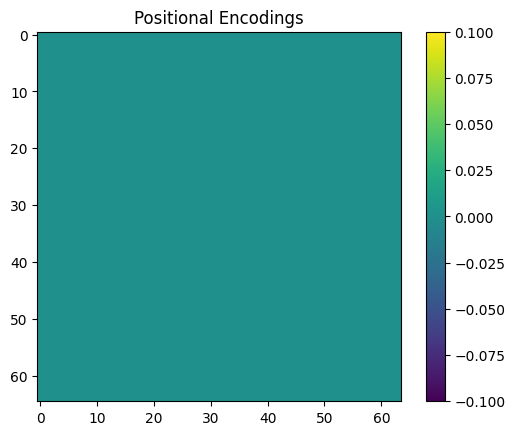

In [88]:
# Example usage
num_patches = patch_embed.num_patches
pos_enc = PositionalEncoding(embed_dim=64, num_patches=num_patches)
pos_enc.visualize_positional_encoding()

# Standard Attention
The StandardAttention class computes attention weights and visualizes them. This class performs the following steps:
- Projects the input patches into queries, keys, and values.
- Computes the attention scores using the dot-product of queries and keys, scaled by the dimension of the keys.
- Applies a softmax function to obtain the attention weights.
- Computes the weighted sum of the values based on the attention weights.
- Projects the result back to the original embedding dimension.


In [74]:
class StandardAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(StandardAttention, self).__init__()
        self.num_heads = num_heads
        self.scale = embed_dim ** -0.5
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_weights = None

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4).unbind(0)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn.detach().cpu().numpy()
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

    def visualize_attention(self, img, layer_num):
        fig, ax = plt.subplots(1, self.num_heads + 1, figsize=(20, 5))
        ax[0].imshow(img.numpy().transpose(1, 2, 0))
        ax[0].set_title('Original Image with Patch Numbers')
        patch_id = 0
        for i in range(0, img.shape[1], 4):
            for j in range(0, img.shape[2], 4):
                rect = plt.Rectangle((j, i), 4, 4, edgecolor='r', facecolor='none')
                ax[0].add_patch(rect)
                ax[0].text(j + 4 // 2, i + 4 // 2, str(patch_id), color='white', ha='center', va='center')
                patch_id += 1

        for i in range(self.num_heads):
            sns.heatmap(self.attn_weights[layer_num, i], ax=ax[i + 1], cbar=True)
            ax[i + 1].set_title(f'Head {i + 1}')
        plt.show()


# Self-Attention
The SelfAttention class implements the self-attention mechanism. Self-attention allows each patch to attend to all other patches within the same image. The steps involved are similar to standard attention but are applied within the same sequence of patches:
- Projects the input patches into queries, keys, and values.
- Computes the attention scores and weights.
- Computes the weighted sum of the values.
- Projects the result back to the original embedding dimension.


In [75]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.num_heads = num_heads
        self.scale = embed_dim ** -0.5
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_weights = None

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4).unbind(0)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn.detach().cpu().numpy()
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

    def visualize_attention(self, img, layer_num):
        fig, ax = plt.subplots(1, self.num_heads + 1, figsize=(20, 5))
        ax[0].imshow(img.numpy().transpose(1, 2, 0))
        ax[0].set_title('Original Image with Patch Numbers')
        patch_id = 0
        for i in range(0, img.shape[1], 4):
            for j in range(0, img.shape[2], 4):
                rect = plt.Rectangle((j, i), 4, 4, edgecolor='r', facecolor='none')
                ax[0].add_patch(rect)
                ax[0].text(j + 4 // 2, i + 4 // 2, str(patch_id), color='white', ha='center', va='center')
                patch_id += 1

        for i in range(self.num_heads):
            sns.heatmap(self.attn_weights[layer_num, i], ax=ax[i + 1], cbar=True)
            ax[i + 1].set_title(f'Head {i + 1}')
        plt.show()


# Cross-Attention
The CrossAttention class demonstrates how patches from a query image can attend to patches from a key and value image, which is useful in encoder-decoder architectures. The process includes:
- Projecting the query image patches into queries.
- Projecting the key and value image patches into keys and values.
- Computing the attention scores and weights between the queries and keys.
- Computing the weighted sum of the values based on the attention weights.
- Projecting the result back to the original embedding dimension.


In [76]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.kv_proj = nn.Linear(embed_dim, embed_dim * 2)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, q, k, v):
        B, N, C = q.shape
        q = self.q_proj(q).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k, v = self.kv_proj(k).reshape(B, -1, self.num_heads, 2, self.head_dim).permute(3, 0, 2, 1, 4).unbind(0)

        attn_weights = (q @ k.transpose(-2, -1)) * self.scale
        attn_weights = attn_weights.softmax(dim=-1)

        out = (attn_weights @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        return out, attn_weights

    def visualize_attention(self, q, k, img, layer_num):
        B, N, C = q.shape
        q = self.q_proj(q).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k, v = self.kv_proj(k).reshape(B, -1, self.num_heads, 2, self.head_dim).permute(3, 0, 2, 1, 4).unbind(0)

        attn_weights = (q @ k.transpose(-2, -1)) * self.scale
        attn_weights = attn_weights.softmax(dim=-1).detach().cpu().numpy()

        fig, ax = plt.subplots(1, self.num_heads + 1, figsize=(20, 5))
        ax[0].imshow(img.permute(1, 2, 0).cpu().numpy())
        ax[0].set_title('Original Image with Patch Numbers')
        patch_id = 0
        for i in range(0, img.shape[1], 4):
            for j in range(0, img.shape[2], 4):
                rect = plt.Rectangle((j, i), 4, 4, edgecolor='r', facecolor='none')
                ax[0].add_patch(rect)
                ax[0].text(j + 4 // 2, i + 4 // 2, str(patch_id), color='white', ha='center', va='center')
                patch_id += 1

        for i in range(self.num_heads):
            sns.heatmap(attn_weights[layer_num, i], ax=ax[i + 1], cbar=True)
            ax[i + 1].set_title(f'Head {i + 1}')
        plt.show()

# Masked Attention
The MaskedAttention class is used to mask certain patches during the attention computation. This is particularly useful in autoregressive models where future patches should not be attended to. The process involves:
- Projecting the input patches into queries, keys, and values.
- Applying a mask to the attention scores to prevent certain patches from attending to others.
- Computing the attention weights and applying the mask.
- Computing the weighted sum of the values based on the masked attention weights.
- Projecting the result back to the original embedding dimension.


In [77]:
class MaskedAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MaskedAttention, self).__init__()
        self.num_heads = num_heads
        self.scale = embed_dim ** -0.5
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_weights = None

    def forward(self, x, mask=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4).unbind(0)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        if mask is not None:
            attn = attn.masked_fill(mask == 0, float('-inf'))
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn.detach().cpu().numpy()
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

    def visualize_attention(self, img, layer_num):
        fig, ax = plt.subplots(1, self.num_heads + 1, figsize=(20, 5))
        ax[0].imshow(img.numpy().transpose(1, 2, 0))
        ax[0].set_title('Original Image with Patch Numbers')
        patch_id = 0
        for i in range(0, img.shape[1], 4):
            for j in range(0, img.shape[2], 4):
                rect = plt.Rectangle((j, i), 4, 4, edgecolor='r', facecolor='none')
                ax[0].add_patch(rect)
                ax[0].text(j + 4 // 2, i + 4 // 2, str(patch_id), color='white', ha='center', va='center')
                patch_id += 1

        for i in range(self.num_heads):
            sns.heatmap(self.attn_weights[layer_num, i], ax=ax[i + 1], cbar=True)
            ax[i + 1].set_title(f'Head {i + 1}')
        plt.show()


In [78]:


class Attention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.scale = embed_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_weights = None  # To store attention weights

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4).unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn.detach().cpu().numpy()  # Save attention weights

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

    def visualize_attention(self, img, layer_num):
        fig, ax = plt.subplots(1, self.num_heads + 1, figsize=(20, 5))
        ax[0].imshow(img.numpy().transpose(1, 2, 0))
        ax[0].set_title('Original Image with Patch Numbers')
        patch_id = 0
        for i in range(0, img.shape[1], 4):
            for j in range(0, img.shape[2], 4):
                rect = plt.Rectangle((j, i), 4, 4, edgecolor='r', facecolor='none')
                ax[0].add_patch(rect)
                ax[0].text(j + 4 // 2, i + 4 // 2, str(patch_id), color='white', ha='center', va='center')
                patch_id += 1

        for i in range(self.num_heads):
            sns.heatmap(self.attn_weights[layer_num, i], ax=ax[i + 1], cbar=True)
            ax[i + 1].set_title(f'Head {i + 1}')
        plt.show()


In [79]:
# Example of Attention Mechanism
attention = Attention(embed_dim=64, num_heads=4)
attended_patches = attention(positional_patches)
print(f'Attended Patches shape: {attended_patches.shape}')

Attended Patches shape: torch.Size([1, 65, 64])


# Multi-Layer Perceptron (MLP)
The MLP class defines a simple feed-forward neural network with two layers. This is typically used in the Vision Transformer after the attention mechanism to process the output embeddings:
- The first layer applies a linear transformation followed by a GELU activation.
- Dropout is applied to prevent overfitting.
- The second layer applies another linear transformation.


In [80]:
class MLP(nn.Module):
    def __init__(self, embed_dim, mlp_dim):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, embed_dim)
        self.act = nn.GELU()
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.drop(self.act(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = Attention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [81]:
# Example of Transformer Block
transformer_block = TransformerBlock(embed_dim=64, num_heads=4, mlp_dim=256)
transformed_patches = transformer_block(attended_patches)
print(f'Transformed Patches shape: {transformed_patches.shape}')

Transformed Patches shape: torch.Size([1, 65, 64])


# Vision Transformer (ViT)
The VisionTransformer class integrates all the components (patch embedding, positional encoding, attention, and MLP) to build the complete Vision Transformer model. The process includes:
- Embedding the input image patches.
- Adding positional encodings to the embedded patches.
- Passing the embedded patches through multiple layers of attention and MLP.
- Applying a classification head to predict the output class.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


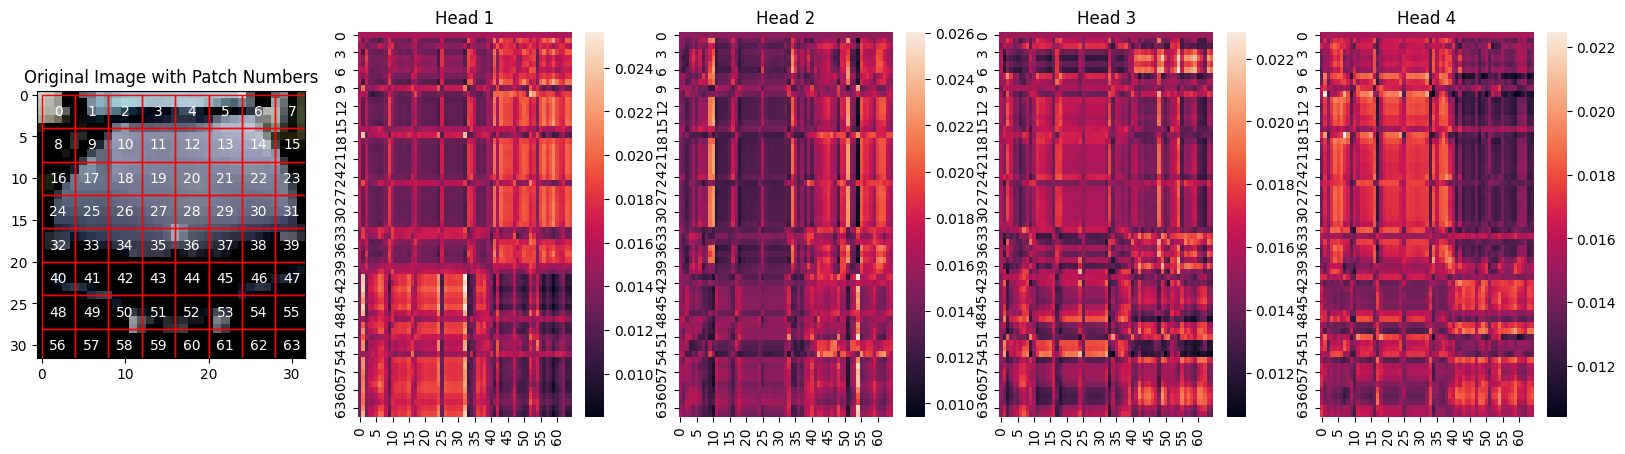

In [82]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, stride=4, in_chans=3, num_classes=10, embed_dim=64, depth=6, num_heads=8, mlp_ratio=4.0):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, stride=stride, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        self.pos_embed = PositionalEncoding(embed_dim=embed_dim, num_patches=num_patches)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.transformer = nn.ModuleList([
            nn.ModuleDict({
                'self_attn': nn.MultiheadAttention(embed_dim, num_heads),
                'mlp': MLP(in_features=embed_dim, hidden_features=int(embed_dim * mlp_ratio), out_features=embed_dim)
            })
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.pos_embed(x)
        for layer in self.transformer:
            attn_output, _ = layer['self_attn'](x, x, x)
            x = attn_output + x
            x = layer['mlp'](x) + x
        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x

# Create the Vision Transformer model
vit_model = VisionTransformer()

# Get a sample image
example_image = images[8].unsqueeze(0)  # Use one image

# Forward pass through the model to generate attention weights
output = vit_model(example_image)

# Visualize the attention maps from a specific layer and head
vit_model.blocks[0].attn.visualize_attention(images[8], layer_num=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


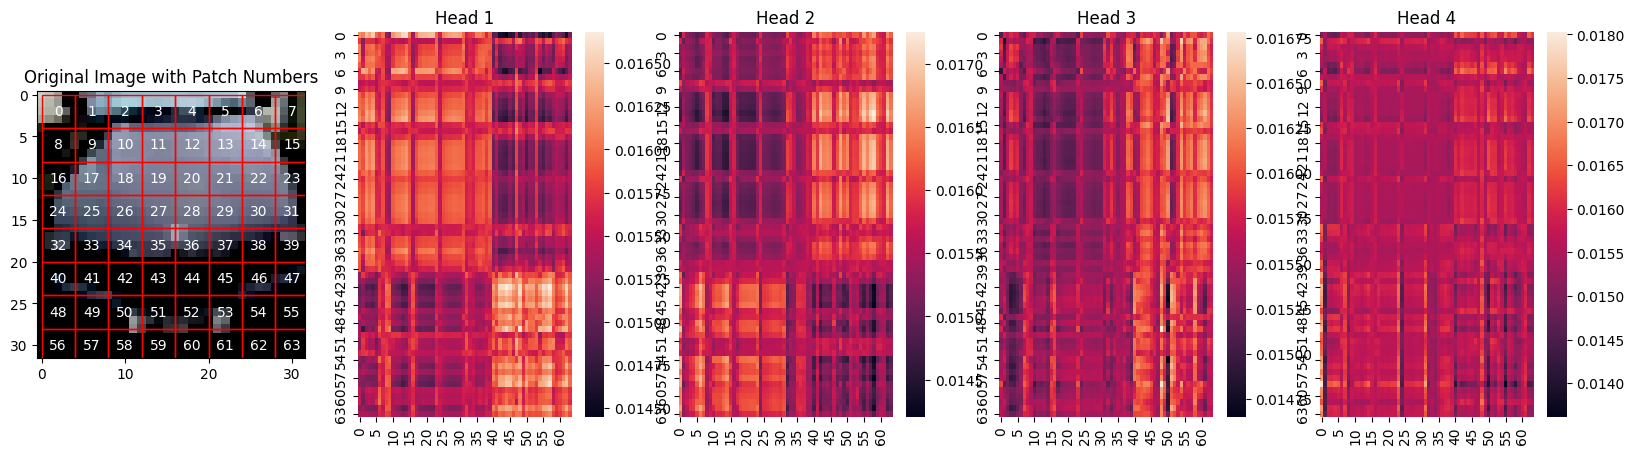

In [83]:
# Example usage for Cross-Attention
cross_attention = CrossAttention(embed_dim=64, num_heads=4)
example_image = images[8].unsqueeze(0)  # Use one image
example_image_patches = patch_embed(example_image)
example_image_patches_with_pos = pos_enc(example_image_patches)

# Assuming you have an encoder output (e.g., from another model)
encoder_output = example_image_patches_with_pos.clone()

# Cross attention from decoder's query to encoder's key and value
output, attn_weights = cross_attention(example_image_patches_with_pos, encoder_output, encoder_output)

# Visualize the attention weights
cross_attention.visualize_attention(example_image_patches_with_pos, encoder_output, images[8], layer_num=0)




# Visualization and Comparison of Attention Mechanisms
In this section, we visualize and compare the attention maps for Standard Attention, Self-Attention, Cross-Attention, and Masked Attention using the CIFAR-10 dataset. These visualizations help in understanding how different types of attention mechanisms work and their effects on the model's focus areas.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


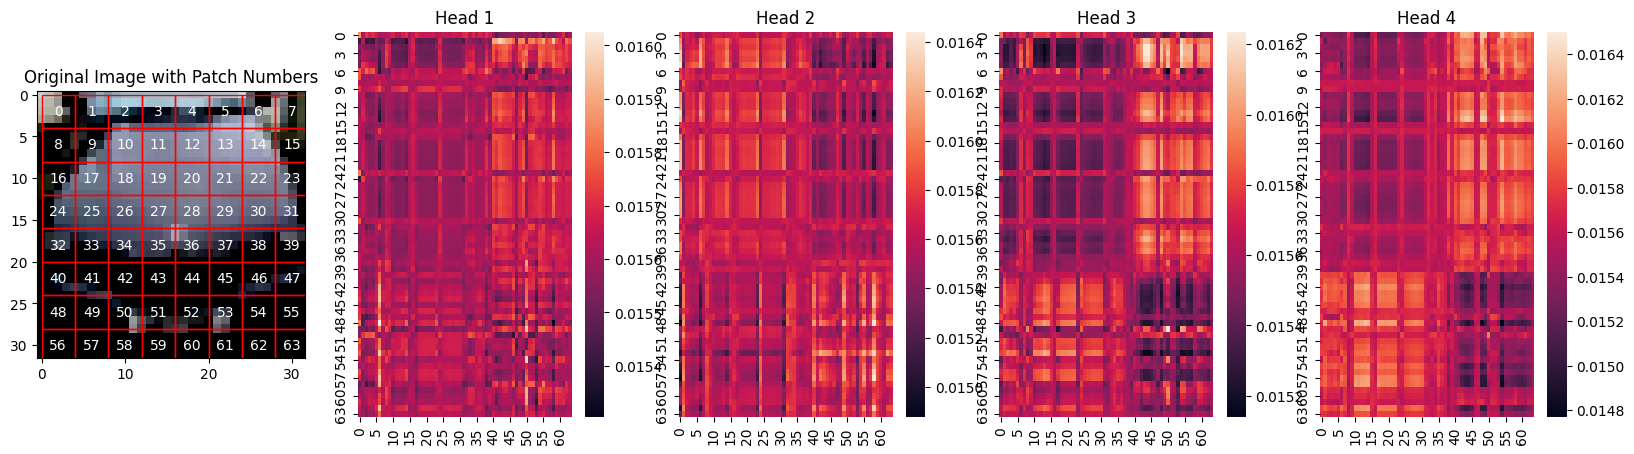

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


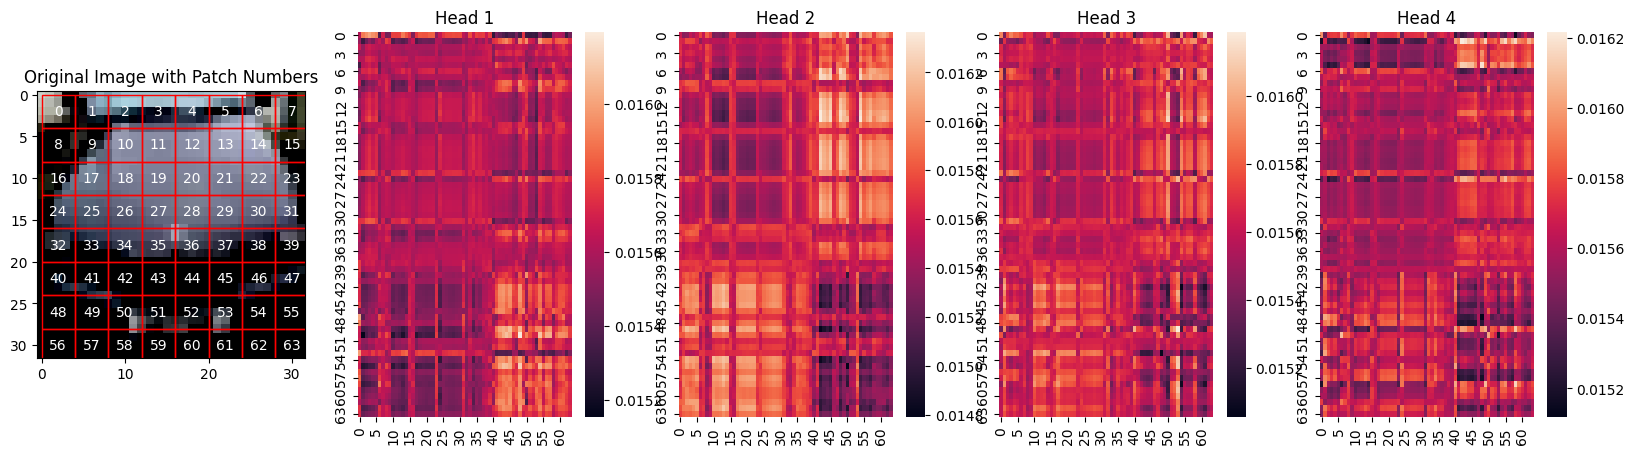

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


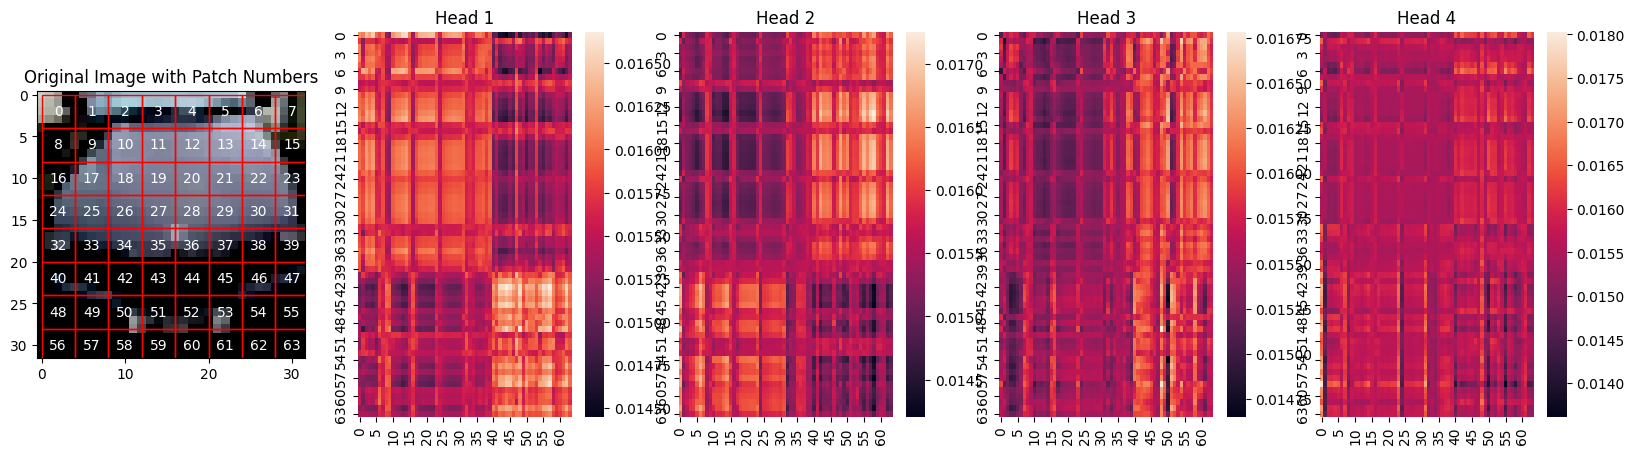

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


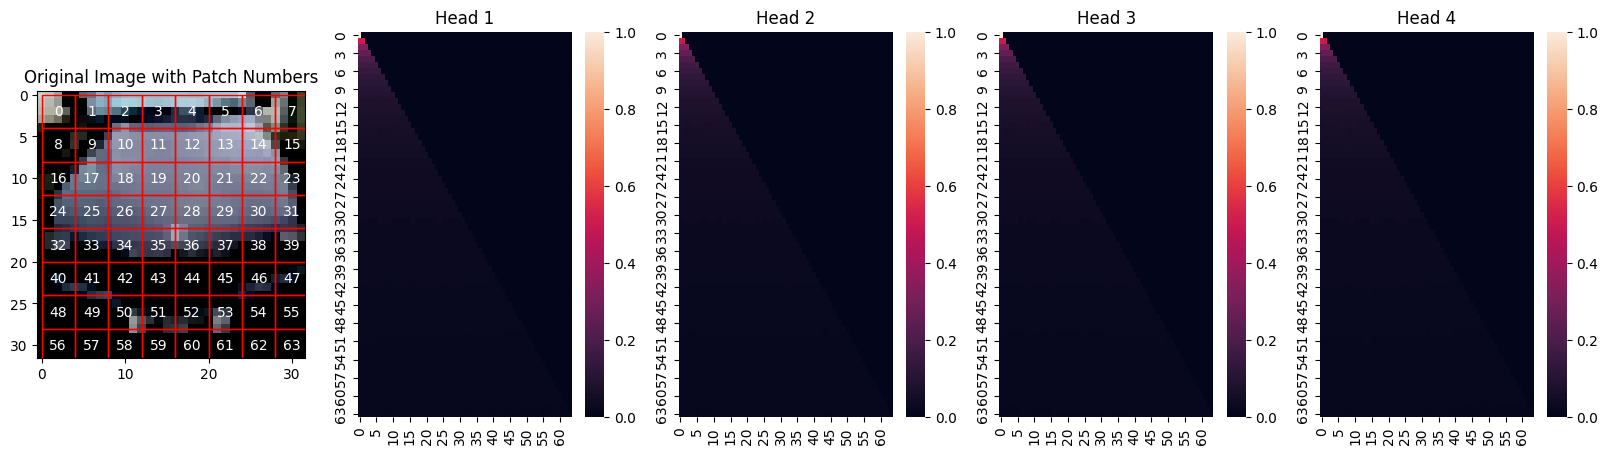

In [84]:
# Visualize Standard Attention
standard_attention = StandardAttention(embed_dim=64, num_heads=4)
standard_output = standard_attention(example_image_patches_with_pos)
standard_attention.visualize_attention(images[8], layer_num=0)

# Visualize Self-Attention
self_attention = SelfAttention(embed_dim=64, num_heads=4)
self_output = self_attention(example_image_patches_with_pos)
self_attention.visualize_attention(images[8], layer_num=0)

# Visualize Cross-Attention
cross_attention.visualize_attention(example_image_patches_with_pos, encoder_output, images[8], layer_num=0)

# Visualize Masked Attention
masked_attention = MaskedAttention(embed_dim=64, num_heads=4)
mask = torch.tril(torch.ones((64, 64))).unsqueeze(0).unsqueeze(0)  # Example mask for 64 patches
masked_output = masked_attention(example_image_patches_with_pos, mask=mask)
masked_attention.visualize_attention(images[8], layer_num=0)


In [85]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model = VisionTransformer().to(device).float()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).float()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

train_model(model, train_loader, criterion, optimizer, num_epochs=5)

def evaluate_model(model, test_loader):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).float()
    acc = running_corrects / len(test_loader.dataset)
    print(f'Test Accuracy: {acc:.4f}')

evaluate_model(model, test_loader)


Epoch 0/4, Loss: 1.7838, Acc: 0.3391
Epoch 1/4, Loss: 1.5629, Acc: 0.4326
Epoch 2/4, Loss: 1.4482, Acc: 0.4757
Epoch 3/4, Loss: 1.3697, Acc: 0.5035
Epoch 4/4, Loss: 1.3132, Acc: 0.5242
Test Accuracy: 0.5291
